In [191]:
import numpy as np
from skimage import io, restoration
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fft2, fftshift
from scipy import fftpack
from PIL import Image
import pywt

(1204, 2044, 3)

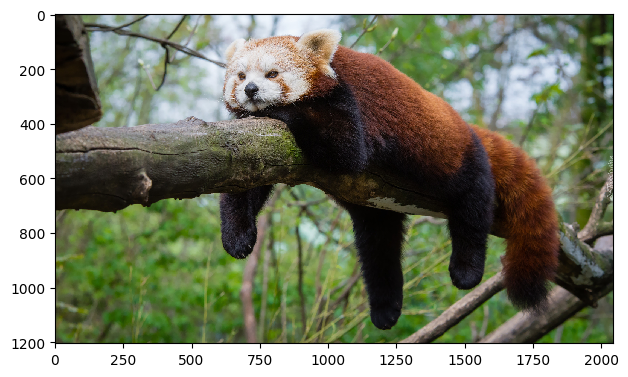

In [192]:
image = io.imread(r"pandaaa.jpg")
io.imshow(image)
image.shape

Zaprojektowana została funkcja implementująca proces nakładania szumu Poissona na obrazy, zarówno w skali szarości, jak i kolorowe.

In [193]:
def poissoning(image, lambda_value=64):
    
    # Generowanie szumu Poissona dla każdego kanału koloru
    noisy_image = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[2]):
        noisy_channel = np.random.poisson(image[:, :, i] / 255.0 * lambda_value) / lambda_value * 255.0
        noisy_image[:, :, i] = np.clip(noisy_channel, 0, 255)

    # Wartości pixeli muszą mieścić się w prawidłowym zakresie [0, 255]
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

In [194]:
def poissoning_gray(image,lambda_value=64):
    noisy_image = np.zeros_like(image, dtype=np.float64)
    noisy_image = np.random.poisson(image / 255.0 * lambda_value) / lambda_value * 255.0
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image    

(1204, 2044, 3)

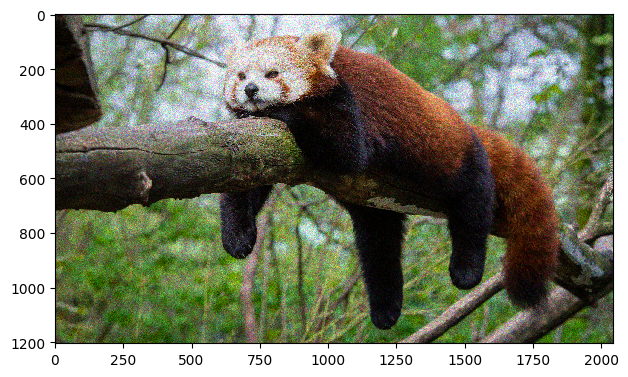

In [195]:
noised_image = poissoning(image,64)
io.imshow(noised_image)
noised_image.shape

Odszumianie zdjęcia kolorowego i szarego za pomocą transformacji Fouriera

In [196]:
#Funkcja, która wyświetla każdy kanał obrazu
def display_TF(image):
    abs_val = np.abs(image)
    plt.figure(figsize=(15,5))
    for i in range(image.shape[2]):
        plt.subplot(1,3, i+1)
        plt.imshow(fftshift(abs_val[:,:,i]), norm=LogNorm(vmin=5))
        plt.title(f"Channel {i + 1}")
        plt.colorbar()
    plt.tight_layout()

Poniższy diagram ilustruje sekwencyjne przedstawienie każdego kanału, na którym zastosowano przekształcenie Fouriera.

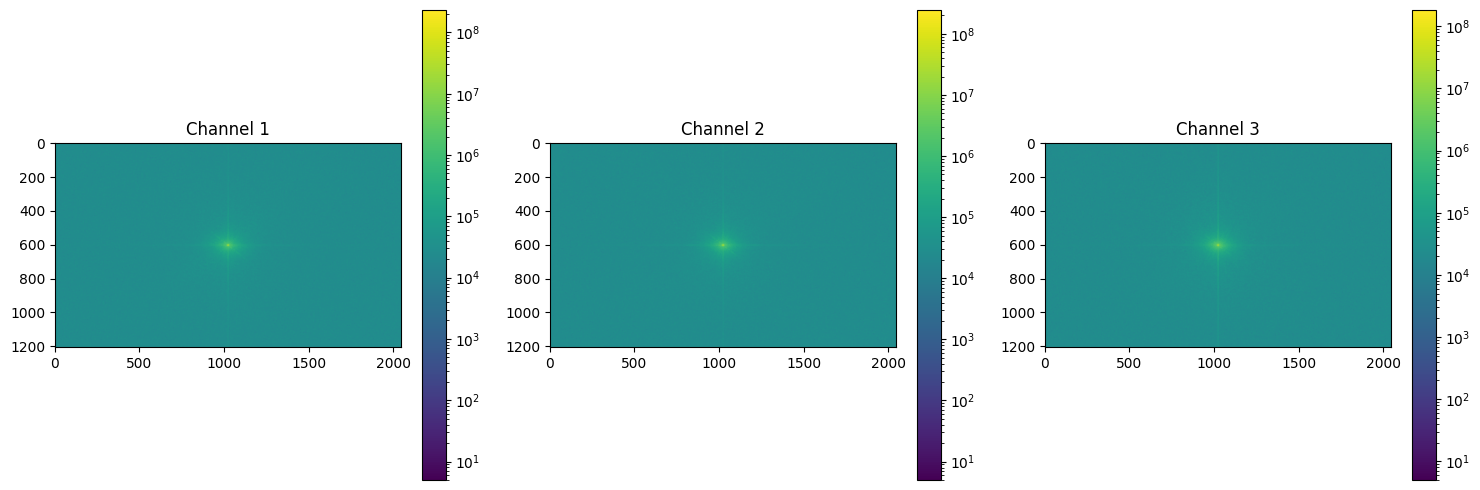

In [197]:
#Przekazanie obrazu do transformaty Fouriera
img_Fourier = np.fft.fft2(noised_image, axes=(0,1))
display_TF(img_Fourier)

Dobór filtra powinien być zgodny z charakterystyką widmową transformaty, czyli reprezentacją częstotliwościową sygnału, jak przedstawiono na powyższym wykresie.

In [198]:
def filter(channel):
    channel[-1000:-200, ] = 0 
    return channel

In [199]:
# Filtrowanie każdego kanału po kolei
def denoising(image):
    denoised_img = np.zeros_like(image,dtype = np.complex128)
    for i in range(image.shape[2]):
        denoised_img[:,:,i] = filter(image[:,:,i])

    return denoised_img

In [200]:
def denoising_gray(image):
    denoised_img = np.zeros_like(image,dtype = np.complex128)
    denoised_img = filter(image)
    return denoised_img

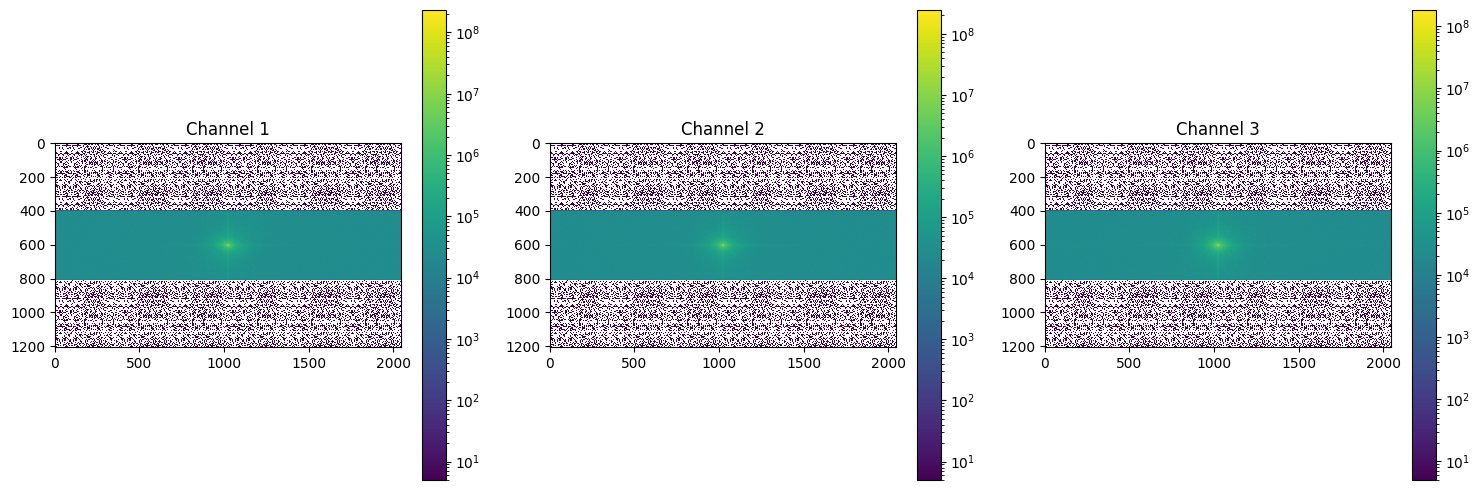

In [201]:
denoised_image_TF = denoising(img_Fourier)
display_TF(denoised_image_TF)

Prezentacja obrazu odszumionego 
przy użyciu transformaty Fouriera. Odpowiedni dobór widma wpływa na lepszą jakość transformaty.

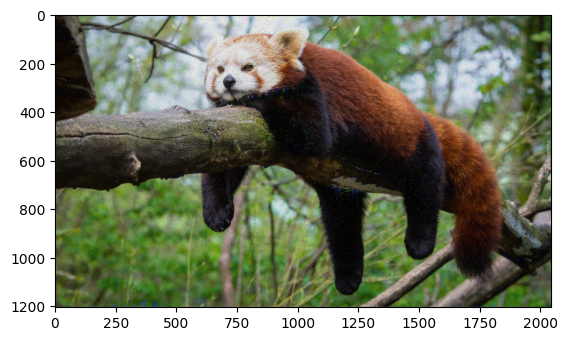

In [202]:
# Funkcja odwrotna do transformaty furiera - przekształcenie obrazu z transformaty na normalny
denoised_image = np.fft.ifft2(denoised_image_TF,axes=(0,1)).real
plt.imshow(np.uint8(denoised_image))

Odszumianie obrazu szarego za pomocą transformacji falkowej.

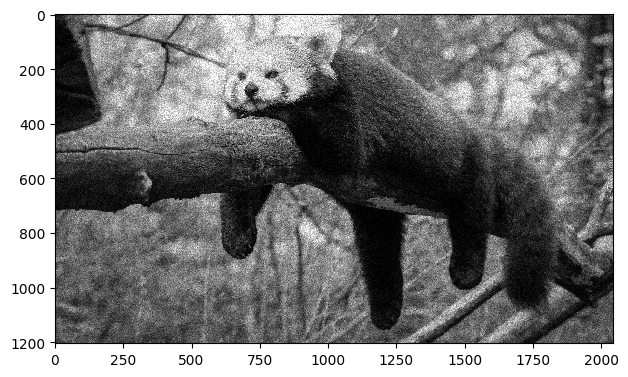

In [203]:
image_gray = cv2.imread("pandaaa.jpg",cv2.IMREAD_GRAYSCALE)
gray_noised = poissoning_gray(image_gray)
io.imshow(gray_noised)

In [204]:
def wavelet_denoise(image,threshold = 0.1):
    
    # Przeprowadzenie transformacji falkowej 
    coeffs2 = pywt.dwt2(image, 'bior1.3')

    # Wartości progowe dla współczynników
    coeffs2 = tuple(map(lambda x: pywt.threshold(x, threshold*np.max(np.abs(x)), mode='soft'), coeffs2))

    # Odtworzenie odszumionego obrazu z przekształconych współczynników
    denoised_image = pywt.idwt2(coeffs2, 'bior1.3')

    # Zaokrąglenie i przekształcenie 
    denoised_image = np.round(denoised_image).astype(np.uint8)

    return denoised_image

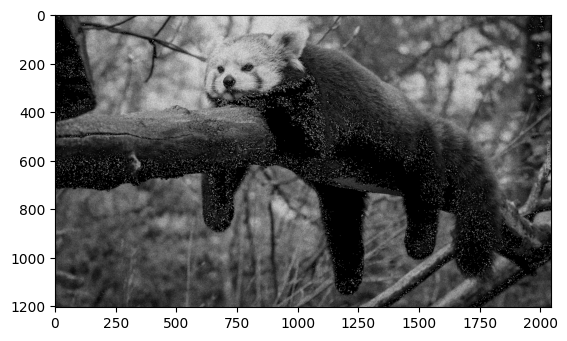

In [205]:
wavelet_denoised = wavelet_denoise(gray_noised, 0.1)

plt.imshow(np.uint8(wavelet_denoised),cmap="gray")

Badanie efektywności odszumiania może być przeprowadzone poprzez analizę trzech różnych metod: transformacji Fouriera, transformaty falkowej oraz rozmycia Gaussowskiego. Transformata Fouriera umożliwia reprezentację sygnału w dziedzinie częstotliwości, co pozwala na eliminację niepożądanych składowych szumowych. Z kolei transformata falkowa charakteryzuje się zdolnością do uwzględniania lokalnych właściwości sygnału, co pozwala na precyzyjne odszumianie. Rozmycie Gaussowskie, z kolei, opiera się na rozkładzie normalnym i eliminuje szum poprzez średnią ważoną pikseli obrazu.

In [206]:
def gaussian_denoising(image, kernel_size=(5, 5), sigma=1.0):
    denoised_image = cv2.GaussianBlur(image, kernel_size, sigma)
    denoised_image = np.round(denoised_image).astype(np.uint8)
    return denoised_image

Text(0.5, 1.0, 'odszumianie Gaussowskie')

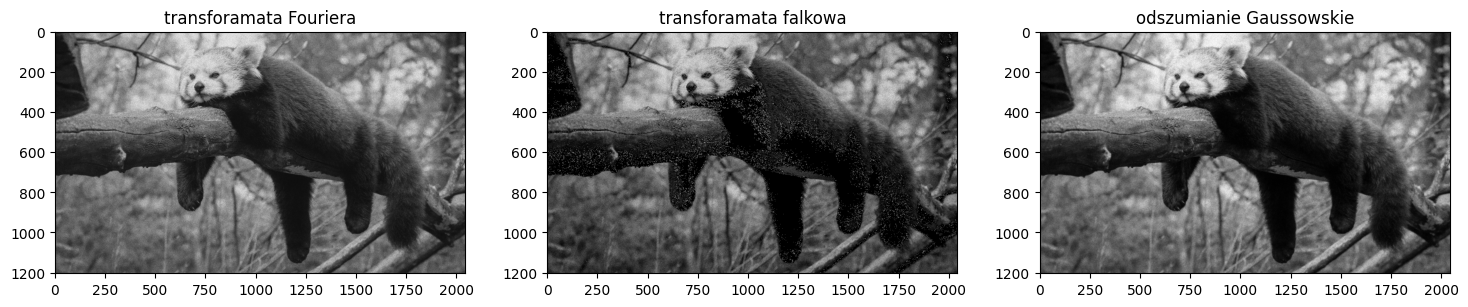

In [207]:
gaussian_denoised = gaussian_denoising(gray_noised)
img_fft = np.fft.fft2(gray_noised,axes=(0,1))
Fourier_denoised = denoising_gray(img_fft)
denoised_image_Fourier_final = np.fft.ifft2(Fourier_denoised,axes=(0,1)).real
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(denoised_image_Fourier_final, cmap="grey")
plt.title("transforamata Fouriera")
plt.subplot(1,3,2)
plt.imshow(wavelet_denoised, cmap="grey")
plt.title("transforamata falkowa")
plt.subplot(1,3,3)
plt.imshow(gaussian_denoised, cmap="grey")
plt.title("odszumianie Gaussowskie")